# Making dataloader

Using the information from `1_intro.ipynb` we will make a dataloader which can produce <br>
(input) one slice of kspace_us, sensitivity, image_us, (label) image_true 

Then, kspace_us, sensitivity, image_us >> Deep Learning Network >> loss(estimated image,image_true) >> backpropagate <br>
The Deep Learning Network can be either `unrolled network` or `U-Net`

In [1]:
import numpy as np
import sigpy as sp
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (10,10)

import sigpy.plot as pl
import os, h5py, pathlib # pathlib is a good library for reading files in a nested folders

from torch.utils.data import DataLoader, Dataset
import torch

import fastmri # We will also use fastmri library
from fastmri.data import subsample, transforms # use for generating undersampling mask, transforming tensors

In [2]:
# This is how you can make a custom dataset class

class MRIDataset(Dataset):
    def __init__(self, root, center_fractions=[0.06,0.06,0.06], accelerations=[4,5,6]):
        self.examples = []
        Files = list(pathlib.Path(root).glob('*.h5'))
        for fname in Files:
            h5file = h5py.File(fname, 'r')
            kspace = h5file['kspace']
            nsl = kspace.shape[0] # get number of slices
            self.examples += [(fname, sl) for sl in range(nsl)]
        
        self.mask_func = subsample.EquispacedMaskFunc(center_fractions=center_fractions, accelerations=accelerations)
    def __len__(self):
        return len(self.examples)
    def __getitem__(self, idx):
        fname, sl = self.examples[idx]
        with h5py.File(fname, 'r') as hr:
            kspace, sens = hr['kspace'][sl], hr['sens'][sl]
        kspace = kspace / 10 # divide by 10 because the values are too large
        im_coil = sp.ifft(kspace, axes=[1, 2])
        im_true = np.sum(im_coil * np.conj(sens), axis=0) # im_true is the fully sampled reconned image
        
        mask = self.mask_func(list(im_true.shape) + [1])[...,0]                              
        mask = np.expand_dims(mask, axis=0)
        masked_kspace = kspace * mask # undersampled kspace
        mask = np.expand_dims(mask, axis=-1)
        
        # Now transform everything to tensor. The complex kspace will be changed to [real, imag] in the final axis
        masked_kspace = transforms.to_tensor(masked_kspace) 
        mask = transforms.to_tensor(mask)
        sens = transforms.to_tensor(sens)
        im_true = np.expand_dims(im_true, axis=0)
        im_true = transforms.to_tensor(im_true)
                        
        return masked_kspace, mask.byte(), sens, im_true



In [3]:
# Then you can use the dataloader like this

basefolder = '/mnt/dense/kanghyun/summer_dset/div_coronal_pd/Test'
dset = MRIDataset(basefolder)

In [4]:
# You can see what's in the dset by looking insider dset.examples

print('Total Slices:',len(dset))
print(dset.examples) # first is path to h5file and second is the slice number


Total Slices: 149
[(PosixPath('/mnt/dense/kanghyun/summer_dset/div_coronal_pd/Test/rawdata_4.h5'), 0), (PosixPath('/mnt/dense/kanghyun/summer_dset/div_coronal_pd/Test/rawdata_4.h5'), 1), (PosixPath('/mnt/dense/kanghyun/summer_dset/div_coronal_pd/Test/rawdata_4.h5'), 2), (PosixPath('/mnt/dense/kanghyun/summer_dset/div_coronal_pd/Test/rawdata_4.h5'), 3), (PosixPath('/mnt/dense/kanghyun/summer_dset/div_coronal_pd/Test/rawdata_4.h5'), 4), (PosixPath('/mnt/dense/kanghyun/summer_dset/div_coronal_pd/Test/rawdata_4.h5'), 5), (PosixPath('/mnt/dense/kanghyun/summer_dset/div_coronal_pd/Test/rawdata_4.h5'), 6), (PosixPath('/mnt/dense/kanghyun/summer_dset/div_coronal_pd/Test/rawdata_4.h5'), 7), (PosixPath('/mnt/dense/kanghyun/summer_dset/div_coronal_pd/Test/rawdata_4.h5'), 8), (PosixPath('/mnt/dense/kanghyun/summer_dset/div_coronal_pd/Test/rawdata_4.h5'), 9), (PosixPath('/mnt/dense/kanghyun/summer_dset/div_coronal_pd/Test/rawdata_4.h5'), 10), (PosixPath('/mnt/dense/kanghyun/summer_dset/div_coronal_

In [5]:
# and you can extract kspace, mask, sens, im_true by indexing
kspace, mask, sens, im_true = dset[20]
# this will take much faster if you copy the dataset to your home directory (SSD)

print(kspace.shape, mask.shape, sens.shape, im_true.shape)
# Notice that everything is in torch tensor

torch.Size([15, 577, 332, 2]) torch.Size([1, 1, 332, 1]) torch.Size([15, 577, 332, 2]) torch.Size([1, 577, 332, 2])


In [6]:
# Change the above variables to numpy again and plot them

kspace = transforms.tensor_to_complex_np(kspace)
sens = transforms.tensor_to_complex_np(sens)
im_true = transforms.tensor_to_complex_np(im_true)
print(kspace.shape, sens.shape, im_true.shape)

(15, 577, 332) (15, 577, 332) (1, 577, 332)


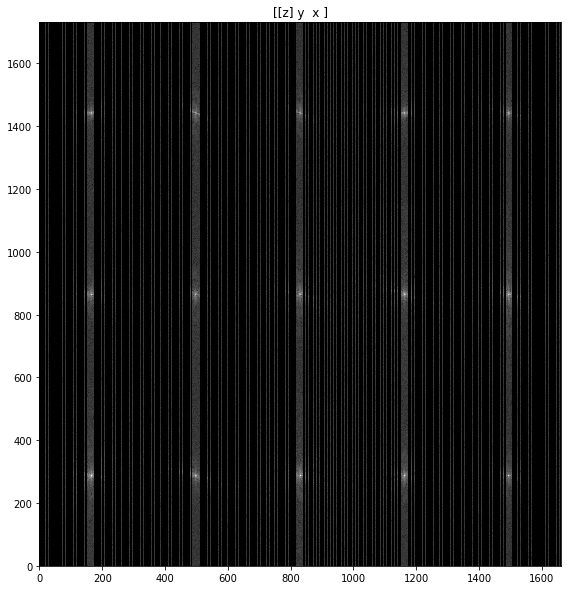

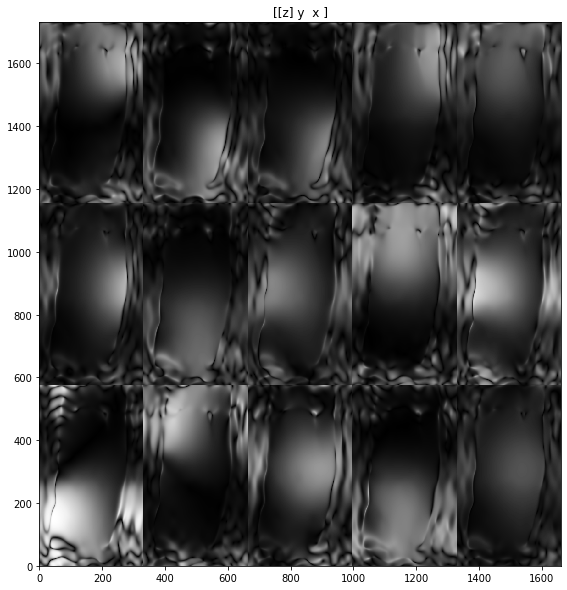

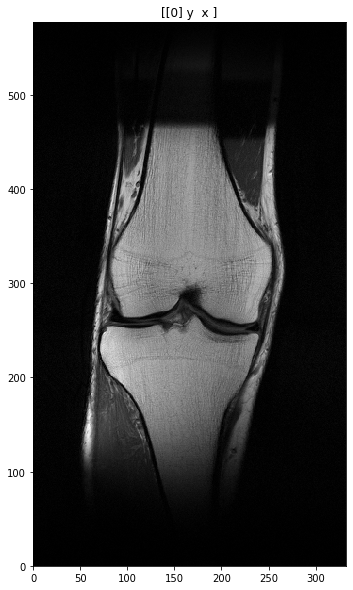

In [7]:
pl.ImagePlot(kspace**0.2,z=0) # this is undersampled kspace
pl.ImagePlot(sens,z=0) # this is sensitivity map
pl.ImagePlot(im_true) # this is true image


In [8]:
# Now let's make pytorch dataloader which can load the dataset automatically and do some useful things likes random shuffling

dloader = DataLoader(dset, batch_size=1, shuffle=True, num_workers=16)
# num_workers can stack 16 minibatch in parallel

# dloader is a generator and you can call it inside a for loop or use iterables

test_dloader = iter(dloader)
kspace, mask, sens, im_true = next(test_dloader) # notice that one more dimension is added
print(kspace.shape, mask.shape, sens.shape, im_true.shape)


torch.Size([1, 15, 577, 332, 2]) torch.Size([1, 1, 1, 332, 1]) torch.Size([1, 15, 577, 332, 2]) torch.Size([1, 1, 577, 332, 2])


(1, 15, 577, 332) (1, 15, 577, 332) (1, 1, 577, 332)


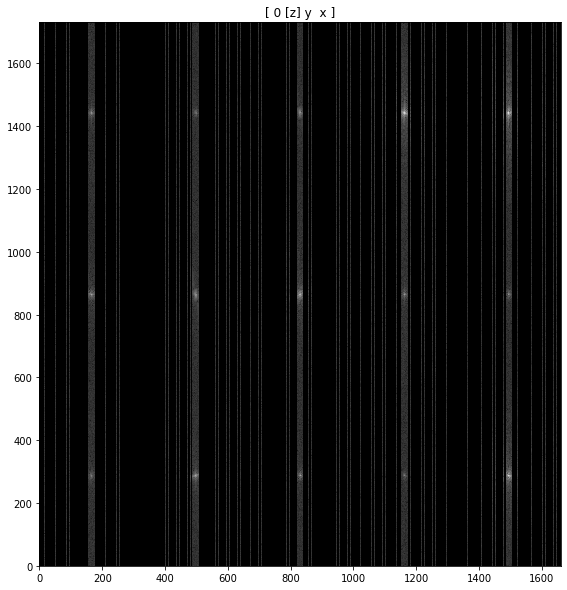

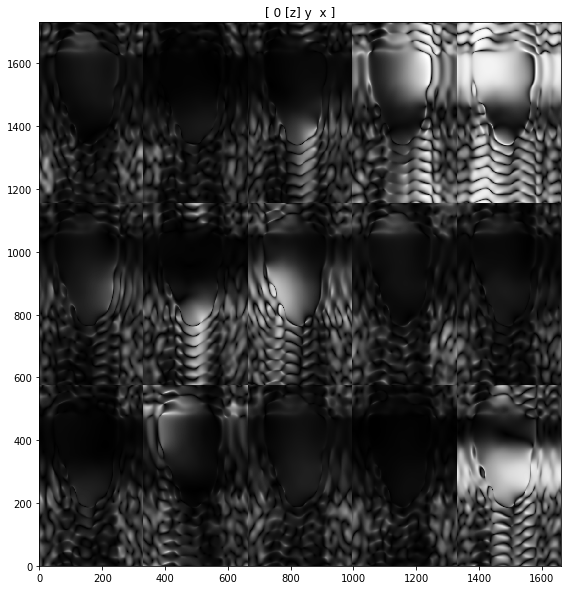

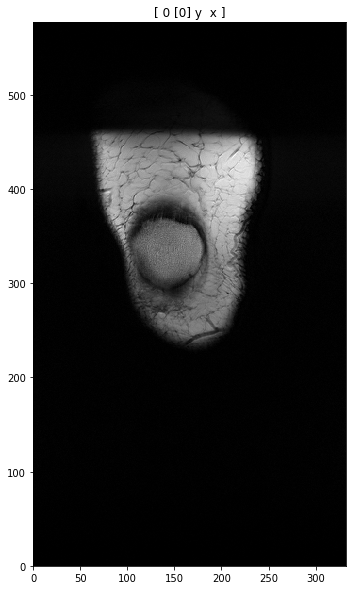

In [9]:
# Change the above variables to numpy again and plot them

kspace = transforms.tensor_to_complex_np(kspace)
sens = transforms.tensor_to_complex_np(sens)
im_true = transforms.tensor_to_complex_np(im_true)
print(kspace.shape, sens.shape, im_true.shape)

pl.ImagePlot(kspace**0.2,z=1) # this is undersampled kspace
pl.ImagePlot(sens,z=1) # this is sensitivity map
pl.ImagePlot(im_true) # this is true image


In [10]:
# now use them inside the for loop like this

for iidx, (kspace, mask, sens, im_true) in enumerate(dloader):
    print('{}th data'.format(iidx))
    print(kspace.shape, mask.shape, sens.shape)


0th data
torch.Size([1, 15, 577, 332, 2]) torch.Size([1, 1, 1, 332, 1]) torch.Size([1, 15, 577, 332, 2])
1th data
torch.Size([1, 15, 577, 332, 2]) torch.Size([1, 1, 1, 332, 1]) torch.Size([1, 15, 577, 332, 2])
2th data
torch.Size([1, 15, 577, 332, 2]) torch.Size([1, 1, 1, 332, 1]) torch.Size([1, 15, 577, 332, 2])
3th data
torch.Size([1, 15, 577, 332, 2]) torch.Size([1, 1, 1, 332, 1]) torch.Size([1, 15, 577, 332, 2])
4th data
torch.Size([1, 15, 577, 332, 2]) torch.Size([1, 1, 1, 332, 1]) torch.Size([1, 15, 577, 332, 2])
5th data
torch.Size([1, 15, 577, 332, 2]) torch.Size([1, 1, 1, 332, 1]) torch.Size([1, 15, 577, 332, 2])
6th data
torch.Size([1, 15, 577, 332, 2]) torch.Size([1, 1, 1, 332, 1]) torch.Size([1, 15, 577, 332, 2])
7th data
torch.Size([1, 15, 577, 332, 2]) torch.Size([1, 1, 1, 332, 1]) torch.Size([1, 15, 577, 332, 2])
8th data
torch.Size([1, 15, 577, 332, 2]) torch.Size([1, 1, 1, 332, 1]) torch.Size([1, 15, 577, 332, 2])
9th data
torch.Size([1, 15, 577, 332, 2]) torch.Size([1

80th data
torch.Size([1, 15, 577, 332, 2]) torch.Size([1, 1, 1, 332, 1]) torch.Size([1, 15, 577, 332, 2])
81th data
torch.Size([1, 15, 577, 332, 2]) torch.Size([1, 1, 1, 332, 1]) torch.Size([1, 15, 577, 332, 2])
82th data
torch.Size([1, 15, 577, 332, 2]) torch.Size([1, 1, 1, 332, 1]) torch.Size([1, 15, 577, 332, 2])
83th data
torch.Size([1, 15, 577, 332, 2]) torch.Size([1, 1, 1, 332, 1]) torch.Size([1, 15, 577, 332, 2])
84th data
torch.Size([1, 15, 577, 332, 2]) torch.Size([1, 1, 1, 332, 1]) torch.Size([1, 15, 577, 332, 2])
85th data
torch.Size([1, 15, 577, 332, 2]) torch.Size([1, 1, 1, 332, 1]) torch.Size([1, 15, 577, 332, 2])
86th data
torch.Size([1, 15, 577, 332, 2]) torch.Size([1, 1, 1, 332, 1]) torch.Size([1, 15, 577, 332, 2])
87th data
torch.Size([1, 15, 577, 332, 2]) torch.Size([1, 1, 1, 332, 1]) torch.Size([1, 15, 577, 332, 2])
88th data
torch.Size([1, 15, 577, 332, 2]) torch.Size([1, 1, 1, 332, 1]) torch.Size([1, 15, 577, 332, 2])
89th data
torch.Size([1, 15, 577, 332, 2]) tor

In [11]:
# Now we will save this code in a separate dloader.py file for further usage